In [266]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib nbagg

Generate a random (stable) IIR filter
--------------

In [267]:
B_len = np.random.randint(5, 10)
A_len = np.random.randint(5, 10)

B = np.random.randn(B_len)
A = np.random.randn(A_len)

In [268]:
def stable_poly(length):
    # all roots inside unit circle and real valued polynomial
    
    roots = np.random.rand((length - 1) // 2) * np.exp(np.random.rand((length - 1) // 2) * 2j * np.pi)
    roots = np.hstack([roots, np.conj(roots)])
    if length % 2 == 0:
        roots = np.hstack([roots, np.random.rand(1) * 2 - 1])
    return np.poly(roots)

In [269]:
A = stable_poly(A_len)

In [270]:
B = stable_poly(B_len) * np.random.randn(1)

In [271]:
stable = (np.abs(np.roots(A)) < 1).all()
stable

True

In [272]:
minphase = (np.abs(np.roots(B)) < 1).all()
minphase

True

In [273]:
N = 100000

In [274]:
def iir_filter(x, B, A, N, y=None):
    if y is None:
        out = np.zeros(N)
        start = 0
    else:
        start = len(y)
        out = np.zeros(N + start)
        out[:start] = y
    
    for i in range(start, N + start):
        o = 0

        for j in range(max(0, i - len(x) + 1), min(i + 1, len(B))):
            o += B[j] * x[i - j]

        for j in range(1, min(i + 1, len(A))):
            o -= A[j] * out[i - j]

        out[i] = o / A[0]
        
    return out

In [275]:
out = iir_filter([1], B, A, N)

<IPython.core.display.Javascript object>


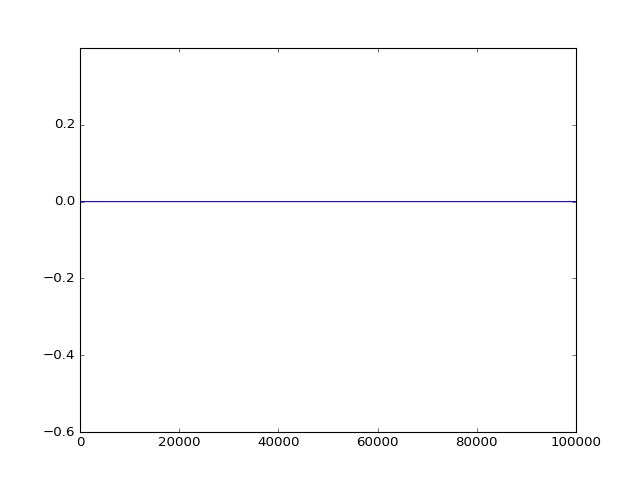

In [276]:
plt.figure()
plt.plot(out)

<IPython.core.display.Javascript object>


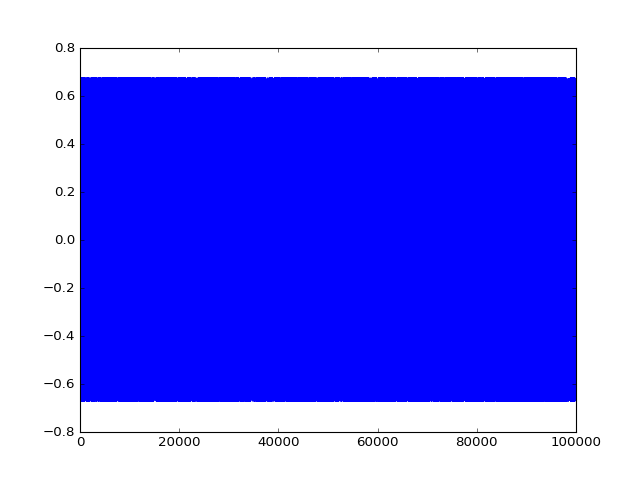

In [277]:
#signal = np.random.randn(N)
signal = np.random.rand(N) > 0.5
out = iir_filter(signal, B, A, N)

plt.figure()
plt.plot(out)

Self Tuning Regulator
---------------------

### NLMS IIR System Identification

In [278]:
n = max(A_len, B_len)

In [279]:
mu = 1

In [280]:
omega = np.zeros(A_len + B_len - 1)#np.random.randn(A_len + B_len - 1)

In [281]:
errors = []

In [282]:
for n in range(max(A_len, B_len), N):
    z = np.hstack([out[n - 1:n - A_len:-1], signal[n:n - B_len:-1]])

    A_est = np.hstack([1, -omega[:A_len - 1]])
    B_est = omega[A_len - 1:]

    y_est = iir_filter(signal[n - max(A_len, B_len):n + 1], B_est, A_est, 1, out[n - max(A_len, B_len):n])

    e = out[n] - y_est[-1]

    errors.append(e)

    omega = omega + mu / np.dot(z, z) * e * z

<IPython.core.display.Javascript object>


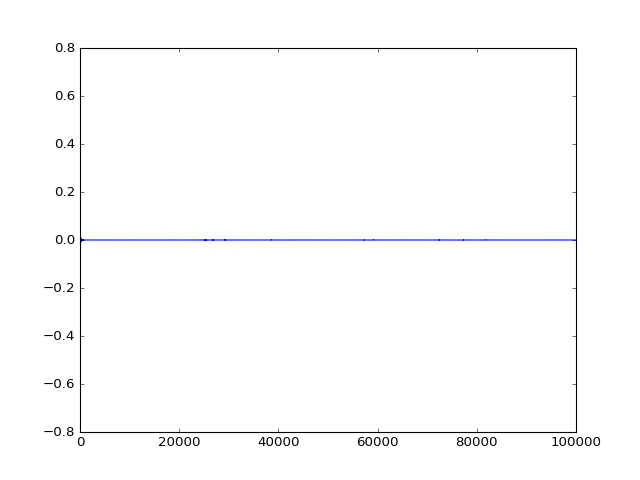

In [283]:
plt.figure()
plt.plot(errors)

In [284]:
A_est, A, B_est, B

(array([  1.00000000e+00,   2.50462171e-01,  -5.39294991e-02,
         -9.68724419e-03,   4.54393695e-03,  -8.59749184e-04,
         -8.38255160e-04,  -1.85054215e-04]),
 array([  1.00000000e+00,  -1.56792629e-01,  -3.25201791e-02,
         -6.00477207e-03,  -2.46241648e-03,  -2.73558462e-04,
         -9.52053622e-06,  -2.55715233e-07]),
 array([  2.61103658e-01,  -4.80082823e-01,   2.34404220e-01,
          2.11486494e-03,  -1.54714789e-02,   1.81000932e-03,
          7.38578909e-04,  -2.42605648e-04,   1.32499095e-04]),
 array([  2.61100648e-01,  -5.86421824e-01,   4.62141009e-01,
         -1.65438775e-01,   3.83095008e-02,  -7.27699342e-03,
          3.96906925e-04,   1.93864871e-04,   3.87775192e-05]))

<IPython.core.display.Javascript object>


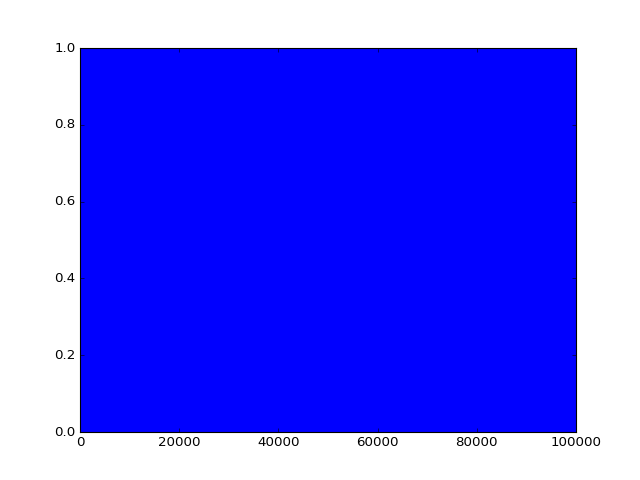

In [285]:
plt.figure()
plt.plot(signal)

Let's try fixed regulation with the estimated filter
----------------------------------------------------

In [286]:
N = 1000

In [287]:
y_ref = np.ones(N) * 80

In [288]:
u = iir_filter(y_ref, A_est, B_est, N)

In [289]:
y = iir_filter(u, B, A, N)

<IPython.core.display.Javascript object>


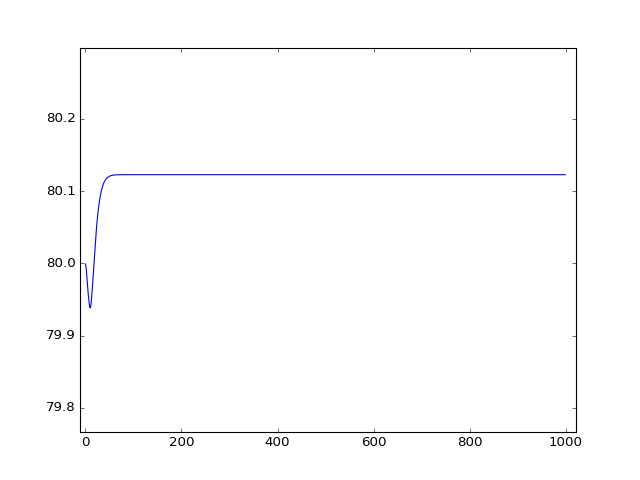

(0, 100)

In [290]:
plt.figure()
plt.plot(y)
plt.ylim(0, 100)

works with some bias

Now we regulate while identifying the system
--------------------------------------------

In [296]:
mu = 0.001
N = 10000

In [297]:
y_ref = np.ones(N) * 50

In [301]:
#omega = np.zeros(A_len + B_len - 1) # start with zeros => division by zero error
#omega = np.random.randn(A_len + B_len - 1) # start with random noise => unstable controller
omega = np.hstack([-A[1:], B]) # start with a perfect estimate -> nothing to do for the adaptation algorithm - works
#omega = np.hstack([-stable_poly(A_len)[1:], stable_poly(B_len)]) => start with stable and minimal phase controller - doesn't work :()

In [302]:
u = []
y = []
errors = []

for n in range(N):
    if n < max(A_len, B_len):
        u.append(1)
        y = iir_filter(u, B, A, 1, y)
        errors.append(y[-1] - y_ref[-1])
    else:
        A_est = np.hstack([1, -omega[:A_len - 1]])
        B_est = omega[A_len - 1:]

        u = iir_filter(y_ref, A_est, B_est, 1, u)
        
        #u[-1] = float(u[-1] > 0.5)
        
        y = iir_filter(u, B, A, 1, y)

        z = np.hstack([y[n - 1:n - A_len:-1], u[n:n - B_len:-1]])
        y_est = iir_filter(u[n - max(A_len, B_len):n + 1], B_est, A_est, 1, y[n - max(A_len, B_len):n])

        e = y[n] - y_est[-1]

        errors.append(e)

        omega = omega + mu / np.dot(z, z) * e * z

<IPython.core.display.Javascript object>


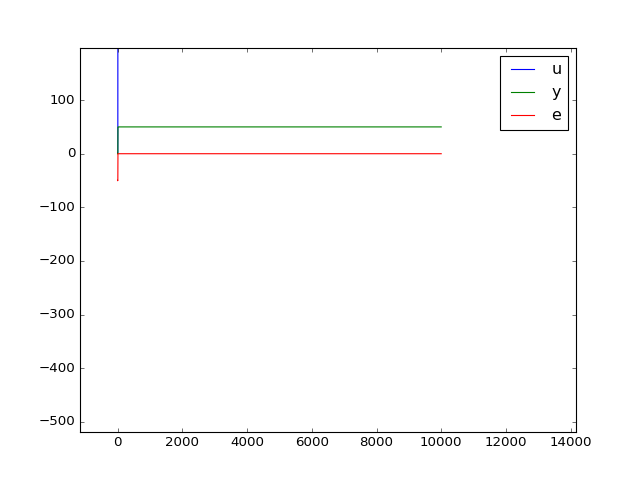

(-100, 100)

In [303]:
plt.figure()
plt.plot(u)
plt.plot(y)
plt.plot(errors)
plt.legend(['u', 'y', 'e'])
plt.ylim(-100, 100)